# Proyecto Final - Text Mining 2021
Garagiola Nazareno


In [2]:
import tweepy
import spacy
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [141]:
f = open('tweets.txt', 'r')
text = f.read()
text = text.split('\n')
corpus = list(set(text))
len(corpus)

998

---
## Leer archivo

### TO DO


1.   Clasficar: bueno vs malo vs neutro con lsita de palabras de valoraicon
1.   Clustering sobre los 
1.   Buscar [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), hacer funcion e intentar implementar





In [142]:
good_val = "top,gusta,buena,entretenida,zarpada,recomiendo,sarpada,buenisima,verla,tremenda,locura,buenarda".split(',')
bad_val = "infumable,absurdo,absurda,mal,malo,malisimo,pesimo,pesima,chota,triste,horrible,mala,malita,fea,malisima,sobrevalorado,sobrevalorada".split(',')

## Procesamiento

In [ ]:
!python -m spacy download es_core_news_md

In [25]:
import spacy
nlp = spacy.load("es_core_news_md")

In [167]:
def convert_listwords(list_words):
    text = ""
    for word in list_words:
        text = text + " " + word
    return text

def evaluate(list_words):
    for word in list_words:
        if word.lower() in good_val:
            return "good"
        elif word.lower() in bad_val:
            return "bad"
    return "neutral"

def clean_tweets(corpus=corpus):
    data = {}
    for position, tweet in enumerate(corpus):
        doc = nlp(tweet)
        list_words = []
        for token in doc:
            if (
                not token.is_punct
                #and not token.is_stop #dejemos las stop por ahora
                and not token.like_url
                and not token.is_space
                #and not token.pos_ == "CONJ"
            ):
                list_words.append(token.lemma_) # hay que tener muuuucho cuidado con esto de lemmatizar todo!
        
        data[position] = {"text": convert_listwords(list_words), "val": evaluate(list_words)}
    return data


In [169]:
data = clean_tweets()
clean = [entry["text"] for entry in data.values()]
val = [entry["val"] for entry in data.values()]

In [173]:
'bad' in val[:10]

False

---
## Algoritmos

In [92]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize(data):
    vectorizer = CountVectorizer(ngram_range=(1,1),stop_words=stop_es) #,strip_accents='unicode')
    matrix = vectorizer.fit_transform(data)
    print(matrix.shape)
    return matrix

In [93]:
corpus_X = vectorize(corpus)
clean_X = vectorize(clean)

(998, 4287)
(998, 3356)


In [174]:
from sklearn.cluster import KMeans

def sklearn_clustering(k, matrix):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(X=matrix)
    return clusterer.labels_

from sklearn.neighbors import KNeighborsClassifier

def sklearn_KNN(X,y):
    classifier = KNeighborsClassifier(n_neighbors=3, p=2) #p=2 euclidean
    classifier.fit(X,y)
    return classifier

from sklearn.manifold import TSNE

def tsne_reduction(matrix):
    tsne = TSNE(n_components=2, random_state=0)
    tsne_data = tsne.fit_transform(matrix)
    return tsne_data

In [177]:
model = sklearn_KNN(X=clean_X, y=val)

In [184]:
model.predict(clean_X[0]), val[0]

(array(['neutral'], dtype='<U7'), 'good')

In [49]:
NUM_CLUSTERS = 3
corpus_sk_cluster =  sklearn_clustering(NUM_CLUSTERS, corpus_X)
corpus_tsne_data = tsne_reduction(corpus_X)

clean_sk_cluster =  sklearn_clustering(NUM_CLUSTERS, clean_X)
clean_tsne_data = tsne_reduction(clean_X)

In [80]:
corpus_row = [(corpus_tsne_data[i], corpus_sk_cluster[i], corpus[i]) for i in range(len(corpus))]
corpus_df = pd.DataFrame(
    data=[(coords[0], coords[1], cluster, word) for coords, cluster, word in corpus_row],
    columns=["dim1", "dim2", "cluster", "tweet"]
)


row = [(clean_tsne_data[i], clean_sk_cluster[i], clean[i]) for i in range(len(clean))]
clean_df = pd.DataFrame(
    data=[(coords[0], coords[1], cluster, word) for coords, cluster, word in row],
    columns=["dim1", "dim2", "cluster", "tweet"]
)


In [81]:
corpus_df.head(3)

,dim1,dim2,cluster,tweet
0,-5.367417,-2.510340,0,Mi top 5 de series coreanas: 1) El juego del c...
1,1.380103,4.503147,2,"""El juego del calamar"": la crisis de la deuda ..."
2,-3.638512,-0.997452,0,@PPTeamRafa De el juego del calamar jsjs


In [82]:
clean_df.head(3)

,dim1,dim2,cluster,tweet
0,0.659773,5.083119,0,Mi top 5 de serie coreano 1 El jugar del cala...
1,-9.450807,5.377795,0,El jugar del calamar lo crisis de lo deuda qu...
2,-3.088195,5.260265,0,@PPTeamRafa De el jugar del calamar jsjs\n


In [57]:

def plot_all(df):
    plt.figure(figsize=(22, 8))
    g = plt.scatter(x=df['dim1'],y=df['dim2'], s=10, c=df['cluster'], cmap='brg', alpha=1)
    plt.colorbar(g)
#for i in range(len(corpus)):
#    plt.annotate(df['cluster'][i], (df['dim1'][i], df['dim2'][i]))
    plt.show()


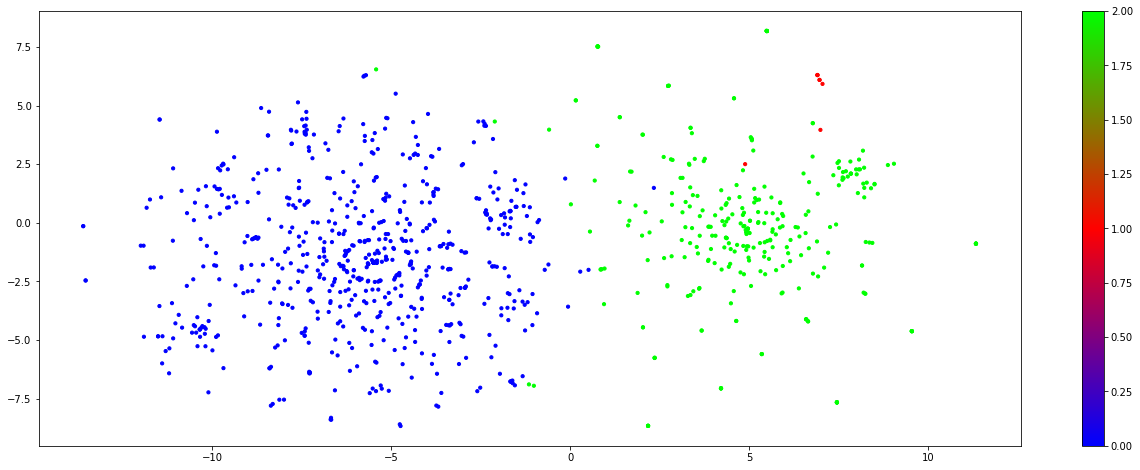

In [59]:
plot_all(corpus_df)

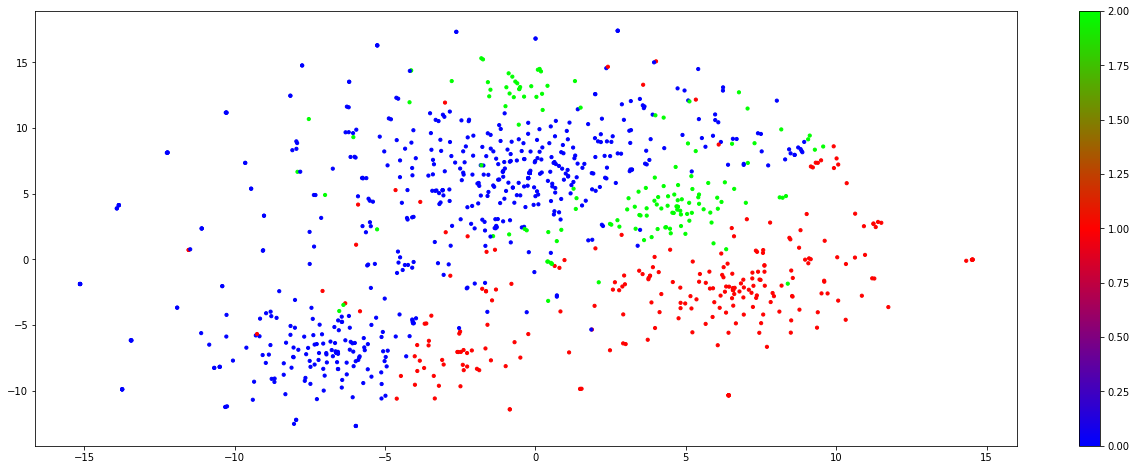

In [58]:
plot_all(clean_df)

In [62]:
def show_cluster(df, n):
    msgs = list(df[df['cluster']==n]['tweet'])
    for msg in msgs:
        text = msg
        print(text)

In [65]:
show_cluster(corpus_df,1)

El Juego del Calamar: ¿Como es la vida de Yeong-su Oh, el jugador 001, luego del exito de la serie?  https://t.co/tyxGHA3Iq8
¿Como vive ahora Yeong-su Oh, el jugador 001, tras el exito mundial de la serie El juego del calamar? https://t.co/rFS7iRoap4
El Juego del Calamar: ¿Como es la vida de Yeong-su Oh, el jugador 001, luego del exito de la serie? https://t.co/UaeXfwRRoE
#24Oct | ¿Como vive ahora Yeong-su Oh, el jugador 001, tras el exito mundial de la serie El juego del calamar?  https://t.co/KcYovLsnqi
¿La serie de Netflix sera llevada a la vida real en Venezuela? Aqui te contamos todos los detalles de la iniciativa que ha surgido en Caracas, Venezuela  https://t.co/ETXxxVPJny
#SquidGame: villano fue #Goku en live-action coreano de #DragonBall  El recordado jugador 101 que se gano el rencor de muchos fans en #SquidGame no siempre tuvo el papel de antagonista, ya que le dio vida al querido saiyajin. https://t.co/16c5yl2AVD
El radical cambio de vida del jugador 001 de #ElJuegoDelCalam

In [83]:
show_cluster(clean_df,1)

 La seriar G.E.O ser uno claro copiar de El Juego del Calamar Los participante perder su identidad y se convertir en numeros Unos soldar dirigir por gente de poder les obligar a realizar prueba muy duro y lo ir eliminar poco a poco Una copiar total 🤷 ‍

 me matar que mi viejo NO PUEDE respetar lo nacionalidad de alguien uno coreano siempre ser uno chinito o uno japón yo le decir no ser chino ser coreano ej el jugar del calamar y me decir ay pero si ser el mismo

 El panico por El jugar del calamar ser tan idiota comer el panico por lo juego de rol https://t.co/MXvg6KWH68

 El senor mayor en el jugar del calamar ser uno personaje que dios tocar el corazon a cualquiera

 El jugar del calamar ser comer el jugar del miedo lo diferenciar ser que ser mucho mas angustiante aun ser menos violentar ya que se poner a probar mas lo moral de los personar que lo voluntad de este por vivir

 Netflix me servir cuando arreglar lo casar y querer sonido de fondo o parir dormir pero encontre uno joyita q

---